# Gaussian Plume Model

This notebook is designed to present the Gaussian Plume model for clarity and understanding. Some code is adopted from [Paul Connolly at the University of Manchester](https://personalpages.manchester.ac.uk/staff/paul.connolly/teaching/practicals/gaussian_plume_modelling.html). Descriptions of the Gaussian Plume model are provided in the [thesis of Christopher Dean at MIT](http://people.csail.mit.edu/cdean/files/sm_thesis.pdf) and in a [2012 paper by Hirst et al](https://arxiv.org/pdf/1211.1409.pdf).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gaussian_plume as gplume
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D

import matplotlib
%matplotlib notebook
%matplotlib inline

First, we will start with defining the standard parameterization associated with wind field "classes" and atmospheric stability. Table 2.1 in Dean's thesis outlines the Pasquill-Gifford stability classes and Table 2.2 provides the coefficients used in the Briggs equations which help to calculate the standard deviations of the horizontal and vertical wind components. We import two methods from our library to get this.

In [2]:
wind_speed = 1.5 #meters/sec
day = True #whether day or night
day_type = 'Strong' #daytime: Strong, Moderate, Slight; nighttime: Clear or Cloudy
urban = True #whether urban or rural

stability_class = gplume.pg_stability_class(wind_speed, day, day_type)
briggs_coeffs = gplume.briggs_coeffs(stability_class, urban)

print('Stability Class: ', stability_class)
print('Briggs_Coefficients: ', briggs_coeffs)

a, b, c, d, e, f = briggs_coeffs
x = np.linspace(100, 100000, 10)
sigma_y = gplume.sigma_y(a, b, c, x)
sigma_z = gplume.sigma_z(d, e, f, x)

Stability Class:  A
Briggs_Coefficients:  (0.32, 0.0004, 0.5, 0.24, 0.0001, -0.5)


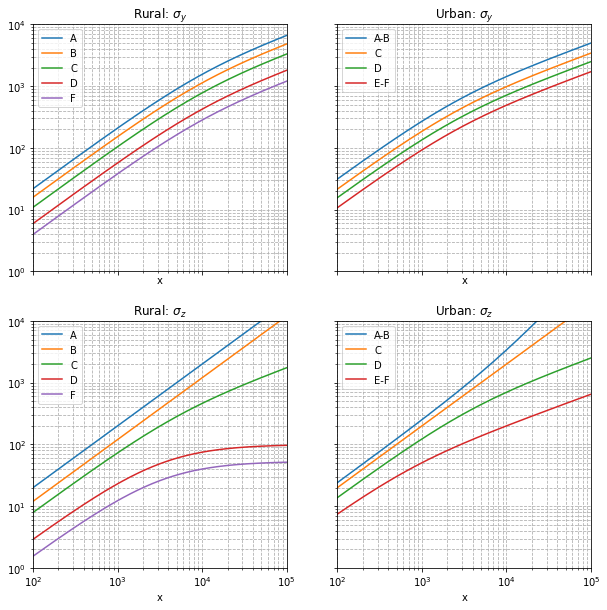

In [3]:
# recreate figure 2.2 in thesis
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10,10))
x = np.linspace(100, 100000, 100000)

ax[0, 0].set_ylim(1, 10000)
ax[0, 0].set_xlim(100, 100000)

#first, rural plots
classes = ['A', 'B', 'C', 'D', 'F']
for stability in classes:
    a, b, c, d, e, f = gplume.briggs_coeffs(stability, urban=False)
    sigma_y = gplume.sigma_y(a, b, c, x)
    sigma_z = gplume.sigma_z(d, e, f, x)
    ax[0, 0].loglog(x, sigma_y, label=c)
    ax[0, 0].set_title('Rural: $\sigma_y$')
    ax[0, 0].set_xlabel('x')
    ax[0, 0].grid(True, which='both', ls='--')
    ax[0, 0].legend(classes)
    ax[1, 0].loglog(x, sigma_z, label=c)
    ax[1, 0].set_title('Rural: $\sigma_z$')
    ax[1, 0].set_xlabel('x')
    ax[1, 0].legend(classes)
    ax[1, 0].grid(True, which='both', ls='--')

#next, urban plots
classes = ['A-B', 'C', 'D', 'E-F']
for stability in classes:
    a, b, c, d, e, f = gplume.briggs_coeffs(stability, urban=True)
    sigma_y = gplume.sigma_y(a, b, c, x)
    sigma_z = gplume.sigma_z(d, e, f, x)
    ax[0, 1].loglog(x, sigma_y, label=c)
    ax[0, 1].set_title('Urban: $\sigma_y$')
    ax[0, 1].set_xlabel('x')
    ax[0, 1].grid(True, which='both', ls='--')
    ax[0, 1].legend(classes)
    ax[1, 1].loglog(x, sigma_z, label=c)
    ax[1, 1].set_title('Urban: $\sigma_z$')
    ax[1, 1].set_xlabel('x')
    ax[1, 1].legend(classes)
    ax[1, 1].grid(True, which='both', ls='--')
    
plt.show()

As noted in both the thesis and the paper, while a useful model if only general atmospheric information is known, it is often more useful to parameterize $\sigma_y$ and $\sigma_z$ with respect to the statistical knowledge of the turbulance in the atmosphere.

To re-parameterize these functions then, let's consider that particles are ejected from some source location $(x, y, z) = (0, 0, 0)$ at some time $t=0$. Let the downward component of the wind be $u$ and crosswind component be $v$ where $v$ is distributed as a zero-mean Gaussian with some variance $\sigma_v^2$. A necessary assumption is that we can neglect wind-speed fluctuation int he $x$ direction, so we can say that particles will be at $x = \bar{u}t$ where $\bar{u}$ is the average wind speed. These particles, also subject to the crosswind will move in that direction $y = vt$, and $\sigma_y = \sigma_vt$. 

In general, we assume that this value of $\sigma_y$ is a maximum, and at some moment in time, it may only be a fraction of this value. Ditto in the vertical direction. We use Draxler's parameterization then to get the following:

$$\sigma_y = \sigma_\theta x f_y(t/T_i)$$
$$\sigma_z = \sigma_\phi x f_z(t/T_i)$$

where $\sigma_\theta = arctan(\sigma_v/u)$ and $\sigma_\phi = arctan(\sigma_w/u)$, each of $\sigma_v$ and $\sigma_w$ being the standard deviations of the horizontal and vertical wind components; $T_i = 1.64T_L$ where $T_L$ is a Lagrangian time scale (different in all three directions); the functions $f_y$ and $f_z$ slow the rate of change of diffusion as downwind distance gets large; and $t$ is the diffusion time.

For the functions, we have the following rules: 
* $t < T_L$ implies $f_y = f_z = 1$
* $t > T_L$ implies that $f_y < 1$ and $f_z < 1$
* for a downwind distance of less than 10km $T_L$ can be dropped
* under stable conditions in the $y$ direction, $T_L = 1000$
* under unstable conditions in the $z$ direction, $T_L = 500$
* under stable conditions in the $z$ direction, $T_L = 100$

For unstable atmosphere, we can use Seinfeld and Pandis approach:

$$f_y(t/T_L) = \frac{1}{(1+ (t/T_L))^{0.5}}$$
$$f_z(t/T_L) = \frac{1}{(1+0.9(t/T_L))^{0.5}}$$

In [4]:
def get_sigmas(stability, x, sigma_v, sigma_w, u):
    '''Method for return sigma_y and sigma_z
    Input:
    - stability (string): unstable or stable conditions
    - x (float): distance downwind
    - sigma_v (float): stdev of horizontal wind
    - sigma_w (float): stdev of vertical wind
    - u (float): downward component of wind
    Output:
    - sigma_y, sigma_z (floats)'''
    
    t = x/u
    
    if stability is "Stable":
        TL_y = 1000*1.64
        TL_z = 100*1.64
    else:
        TL_y = 1000*1.64
        TL_z = 500*1.64
    
    theta = np.arctan(sigma_v/u)
    phi = np.arctan(sigma_w/u)
    
    fy = 1/(1 + (t/TL_y)**0.5)
    fz = 1/(1+0.9*(t/TL_z)**0.5)
    
    return theta*x*fy, phi*x*fz

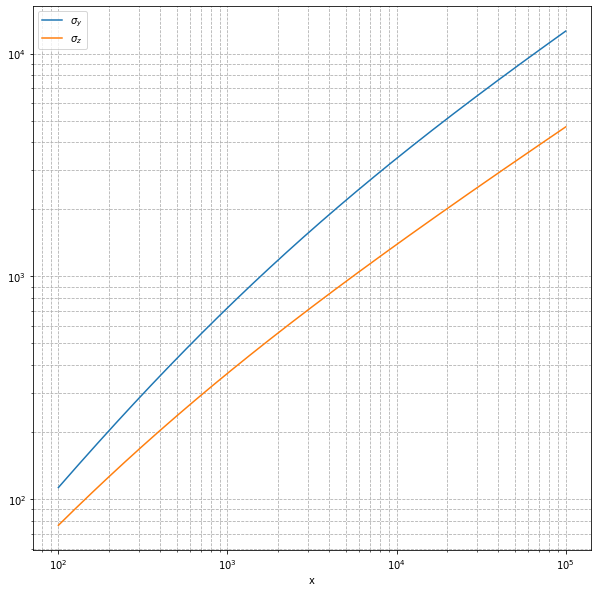

In [5]:
#illustrate the continuous parameters
plt.figure(figsize=(10,10))
sigma_y, sigma_z = get_sigmas('Stable', x, 10.0, 10.0, 0.5)
plt.loglog(x, sigma_y, label='$\sigma_y$')
plt.loglog(x, sigma_z, label='$\sigma_z$')
plt.grid(True, which='both', ls='--')
plt.xlabel('x')
plt.legend()

Now, we can get to the actual model. Let $C(x,y,z)$ be the concentration of some chemical or particulate matter at a location in 3-space. It can be factored into downwind, cross-wind, and vertical coordinates which we'll note as $\phi_x, \phi_y, \phi_z$ respectively. 

Let the $x$ direction be deterministically diluted by wind. Assume the source is emitting at some constant rate $Q$ and wind speed is $u$, then:

$$\phi_x = \frac{Q}{u}$$

The cross-wind direction can be modelled as a normal distribution:

$$\phi_y = \frac{1}{\sqrt{2\pi}\sigma_y}exp(-\frac{y^2}{2\sigma_y^2})$$

The vertical direction can also be modelled as a normal:

$$\phi_z = \frac{1}{\sqrt{2\pi}\sigma_z}exp(-\frac{(z-H)^2}{2\sigma_z^2})$$


Where $H$ is the effective source height and plume rise. For practical reasons (i.e., plume rise is not unbounded), $\phi)z$ is often modelled as:

$$\phi_z = \frac{1}{\sqrt{2\pi}\sigma_z}(exp(-\frac{(z-H)^2}{2\sigma_z^2}) + exp(-\frac{(z+H)^2}{2\sigma_z^2}))$$


If we would like to consider the bounds of the mixing layer with depth $D$ we can also express it as:

$$\phi_z = \frac{1}{\sqrt{2\pi}\sigma_z}\sum_{j=-\infty}^{\infty}(exp(-\frac{(z-(H+2jD))^2}{2\sigma_z^2}) + exp(-\frac{(z+(H+2jD))^2}{2\sigma_z^2}))$$



In [6]:
def concentration(x, y, z, Q, u, sigma_y, sigma_z, H, D=None):
    ''' Method that returns particular concentration
        Inputs:
            - x (float) x-coordinate in state space
            - y (float) y-coordinate in state space
            - z (float) z-coordinate in state space
            - Q (float) source emission rate
            - u (float) wind speed
            - sigma_y (float) cross-wind variance
            - sigma_z (float) vertical-wind variance
            - H (float) effective source height
            - D (float) mixing layer depth (if relevant)'''
    
    def phi_x(Q, u):
        ''' Method to return the downwind dispersion
            Inputs:
                - Q (float) source emission rate
                - u (float) wind speed'''
        return Q/u

    def phi_y(sigma_y, y):
        ''' Method to return the crosswind dispersion (normal distribution)
            Inputs:
                - sigma_y (float) crosswind variance
                - y (float) y-coordinate in state space'''
        if np.sum(sigma_y) > 0.0:
            return 1/(np.sqrt(2*np.pi)*sigma_y)*np.exp(-np.power(y,2)/(2*np.power(sigma_y,2)))
        else:
            return 0.0

    def phi_z(sigma_z, z, H, D=None):
        ''' Method to return the vertical dispersion
            Inputs:
                - sigma_z (float) vertical variance
                - z (float) z-coordinate in state space
                - H (float) effective height of source emission
                - D (float) mixing layer depth'''
        if np.sum(sigma_z) > 0.0:
            if D is None:
                #return the classic definition
                return 1/(np.sqrt(2*np.pi)*sigma_z)*(np.exp(-np.power(z-H, 2)/(2*np.power(sigma_z,2))) + np.exp(-np.power(z+H,2)/(2*np.power(sigma_z,2))))
            else:
                # return mixing layer version
                summer = 0
                for i in range(-2,2):
                    summer += np.exp(-(z-(2*i*D+H))**2/(2*sigma_z**2)) + np.exp(-(z+(H+2*i*D))**2/(2*sigma_z**2))
                return 1/(np.sqrt(2*np.pi)*sigma_z) * summer
        else:
            return 0.0

    return phi_x(Q,u)*phi_y(sigma_y, y)*phi_z(sigma_z, z, H, D)

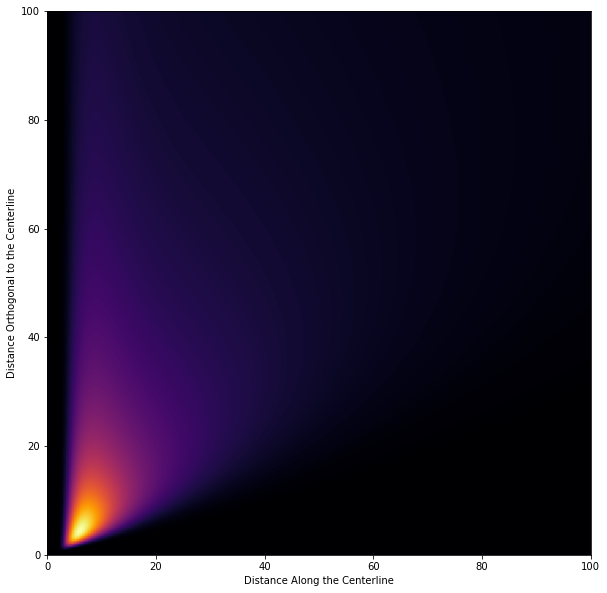

In [7]:
px = np.linspace(0, 100, 200) #x poses, along the center line
py = np.linspace(0, 100, 200) #y poses, away from the center line
pz = 30 #z poses
Q = 100 #emission rate
u = 0.5 #windspeed
sigma_y, sigma_z = get_sigmas('Stable', px, 5.0, 5.0, u)
H = 20 #emission height

conc = np.zeros((len(px), len(py)))
for i, x in enumerate(px):
    for j, y in enumerate(py):
        conc[i, j] = concentration(x, y, pz, Q, u, sigma_y[i], sigma_z[j], H)

plt.figure(figsize=(10,10))
plt.imshow(conc, cmap='inferno', origin='lower', extent=(0, 100, 0, 100))
plt.xlabel('Distance Along the Centerline')
plt.ylabel('Distance Orthogonal to the Centerline')
plt.show()

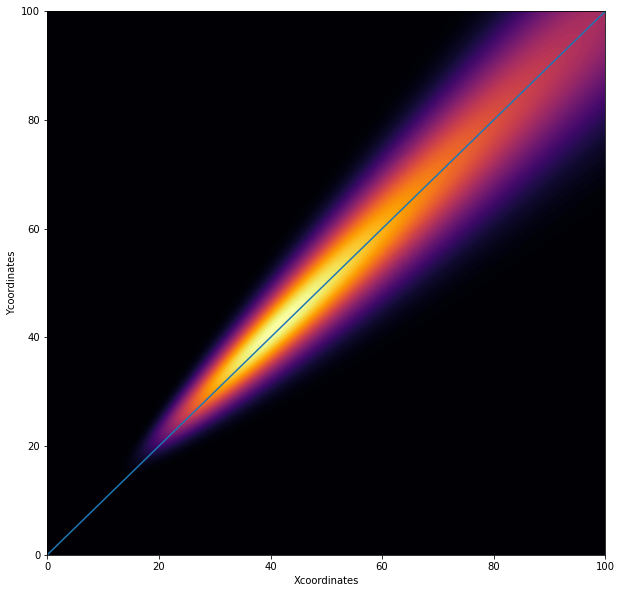

In [8]:
#visualize a "real" plume, assume plume is at 0, 0, pointing along the y=x line
px = np.linspace(0, 100, 200) #x poses, along the center line
py = np.linspace(0, 100, 200) #y poses, away from the center line
pz = 34 #z poses
Q = 100 #emission rate
u = 10.5 #windspeed
sigma_y, sigma_z = get_sigmas('Stable', px, 1.0, 1.0, u)
H = 29 #emission height

conc = np.zeros((len(px), len(py)))
for i, x in enumerate(px):
    for j, y in enumerate(py):
        dist = np.sqrt(x**2+y**2) #vector from origin to query point
        dist_ang = np.arctan(y/x) #vector angle from origin to query point
        
        plume_ang = np.pi/4. #from given
        phi = plume_ang-dist_ang
        rho = plume_ang+dist_ang
        ortho_dist = dist*np.sin(phi)
        along_dist = dist*np.sin(rho)
        
        conc[j, i] = concentration(along_dist, ortho_dist, pz, Q, u, sigma_y[i], sigma_z[j], H)

plt.figure(figsize=(10,10))
plt.contourf(px, py, conc, cmap='inferno', vmin=0, levels=np.linspace(np.nanmin(conc), np.nanmax(conc), 100))
plt.plot(px, px)
plt.xlabel('Xcoordinates')
plt.ylabel('Ycoordinates')
plt.show()

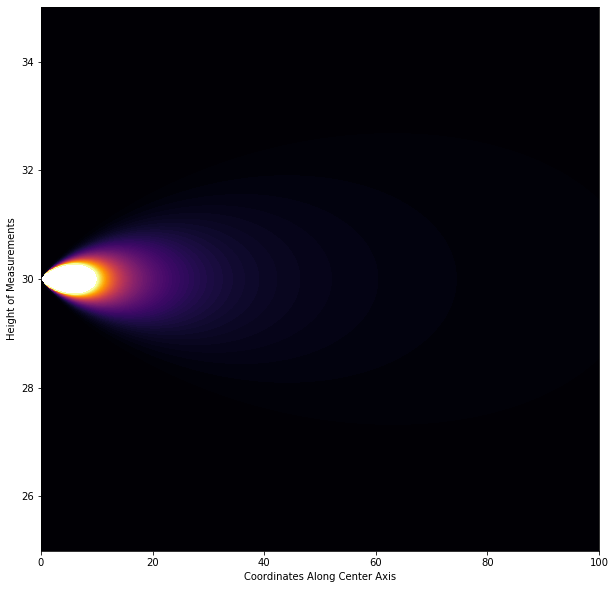

In [9]:
#visualize a "real" plume, assume plume is at 0, 0, pointing along the y=x line
p = np.linspace(0, 100, 200) #poses, along the center line
pz = np.linspace(25, 35, 200) #z poses
Q = 100 #emission rate
u = 30.5 #windspeed
sigma_y, sigma_z = get_sigmas('Stable', p, 1.0, 1.0, u)
H = 30 #emission height

conc = np.zeros((len(p), len(pz)))
for i, x in enumerate(p):
    for k, z in enumerate(pz):
        conc[k, i] = concentration(x, 0, z, Q, u, sigma_y[i], sigma_z[i], H)
        
plt.figure(figsize=(10,10))
plt.contourf(p, pz, conc, cmap='inferno', levels=np.linspace(0, 5, 100))
plt.xlabel('Coordinates Along Center Axis')
plt.ylabel('Height of Measurements')
plt.show()

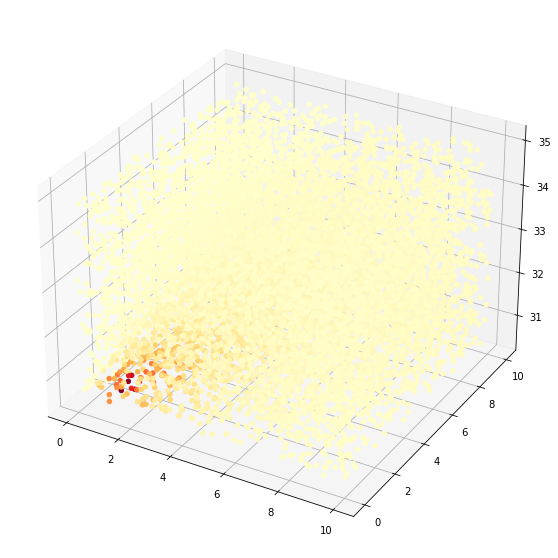

In [10]:
#visualize a "real" plume, assume plume is at 0, 0, pointing along the y=x line, in 3D
px = np.random.uniform(0, 10, 10000) #x poses, along the center line
py = np.random.uniform(0, 10, 10000) #y poses, away from the center line
pz = np.random.uniform(30.5, 35, 10000)
Q = 10000 #emission rate
u = 1.5 #windspeed
sigma_y, sigma_z = get_sigmas('Stable', px, 1.0, 1.0, u)
H = 30 #emission height

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

dist = np.sqrt(np.power(px,2)+np.power(py,2)) #vector from origin to query point
dist_ang = np.arctan(py/px) #vector angle from origin to query point

plume_ang = np.pi/4. #from given
phi = plume_ang-dist_ang
rho = plume_ang+dist_ang
ortho_dist = dist*np.sin(phi)
along_dist = dist*np.sin(rho)
ctemp = concentration(along_dist, ortho_dist, pz, Q, u, sigma_y, sigma_z, H)

ax.scatter(px, py, pz, c=ctemp, cmap='YlOrRd', alpha=1.0)
plt.show()

## Background Model
In a complete system, we would like to consider the background atmospheric levels. 

## Probabilistic Model 
In order to solve the inverse problem, of inferrning parameters such as number of sources, source locaiton, and emission rate from a set of noisy concnetration measruments, we must define a probabilistic generative model for how concentration measurements are generated from sources and solve the inference problem, which inverts the generative model to infer model parameters from measurements.

### Model Parameters
Define the following model parameters: 

#### Plume location model 
$ m $ - the number of sources 

$ \mathbf{x} = \{x_j \}_{j = 1}^m $ - the locations of each source

$ \mathbf{w^2} = \{w_j^2 \}_{j = 1}^m $ - the isotropic covariance/width of each source location

$ \mathbf{s} = \{s_j \}_{j = 1}^m $ - the emission rate of each source, in $m^3 / s$


Therefore, when generating a particle, the exact release location for each particle is given by a 2D Gaussian distribution $ \mathcal{N}(x_j, w_j^2 \mathbf{I})$. 

#### Observation parameters

The following defines the variables that define the measurments taken by the sensor:

$f_s$ - the sampling rate of the aircraft

$ \mathbf{z} = \{z_i \}_{i = 1}^n $ - the $n$ concentration measurements

$ \mathbf{y} = \{y_i \}_{i = 1}^n $ - the 2D locations of the $n$ concentration measurements

$ \mathbf{t} = \{t_i \}_{i = 1}^n $ - the times of the $n$ concentration measurements

$ \mathbf{\epsilon} = \{\epsilon_i \}_{i = 1}^n $ - the noise in the $n$ concentration measurements, where $\epsilon_i \sim \mathcal{N}(0, \sigma_\epsilon^2)$

Each of the above measurements is taken in the precense of background ambient concentration. The background contributions are denotes as:

$ \mathbf{b} = \{b_i \}_{i = 1}^n $ - the background concentrations at time $\mathbf{t}$ and locations $\mathbf{y}$. 

In general, the background concnetration can be within an order of magnitude of the plume concentrations, and therefore careful modeling of the background concentration is necessary to estimate the contriubtion due to the plume emissions. 

An understanding of wind speed is also necessary to properly infer plume dispersion paramters. The set of wind speed measurements is denoted:

$ \mathcal{W} = \{\{u_i\}_{i = 1}^n, \gamma_H, \gamma_V \} $. 

Therefore, at each measurement location, there is a 2D wind vector $u_i$, as well as the wind direction standard deviation (aka horizontal plume opening angle) $\gamma_H$ and the vertical wind speed standard deviation (aka verticle plume opening angle) $\gamma_V$. Currently, the wind model is restricted to 2D, although wind speed is known to change depending on hieght and a 3D wind model may be more informative.

### Observation Model 

Each observation is generated according to a mixture of the $m$ sources (linear combination):

$$ z_i = \sum_{j = 1}^m a_{ij}s_j + b_i + \epsilon_i $$ 

where $a_{ij}$ is known as the coupling stregnth between measurement at location $i$ and the source $j$. This stregnth is defined by a ''coupling function'' $a$ that depends on the relative locations of the source and observation, the width of each source,a nd the wind information, such that:

$$ a_{ij} = a(y_i, x_j, w_j ; \mathcal{W}) $$

This equation can be rewritten as:

$$ \mathbf{z} = \mathbf{A}\mathbf{s} + \mathbf{b} + \mathbf{\epsilon} $$

where $\mathbf{A}$ is the coupling matrix.


### Dispersion Model

The Gaussian plume model provides a closed-form expression for expected concentration at a location $y$ due to source with a unit emission rate located at location $x$ and with width $w$. 

Because dipersion is always defined in the frame of the prevailing wind direction, the measurement locations in some reference frame $\mathbf{x}, \mathbf{y}$ must be rotated into the coordinate axis defined by the wind.

Let $\delta_R$ be the rotated downwind distance, $\delta_H$ the cross-wind distance, and $\delta_V$ the vertical distance, obtained by multiplying the observation and source locations by a standard rotation matrix. 


One important differnce between the model as forumlated and the standard Gaussian plume model is that the plumes in this model have a width $w_i$, whereas in the Gaussian plume model, they are point sources. This is resolved simply by adding the means and variances of the source width and the cross-wind dispersion model. 

This produces a final coupling function:

$$ a(\mathbf{\delta}, w_j; \mathcal{W}) = \frac{1}{2 \pi |\mathbf{u}_i| \sigma_H \sigma_V} \text{exp}\{ -\frac{\delta_H^2}{2 \sigma_H^2} \}  \times \sum_{j = -N}^M \text{exp} \{ - \frac{\delta_V - (H + 2jD))^2}{2\sigma_V^2} \} + \text{exp} \{ - \frac{\delta_V - (H + 2jD))^2}{2\sigma_V^2} \}. $$

where $H$ is the hight of the source and the atmospheric boundary level is the $D$.

### Background Model

The background contributions $b_i$ is constrained to be positive and spatially and temporally smooth using a Gaussian Markov random field (GMRF), to model correlation between sample points. 

The correlations between sample points is modeled as an undirected graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$. The edge set defines the structure of the Gaussian precision matrix $J$. A parameter $mu$ determines how the smoothness of the background is weighted relative to noise. 

Therefore, under this model:

$$ \mathbf{b} \sim \mathcal{N}(\mathbf{b}; \mathbf{b}_0, (\mu \mathbf{J})^{-1}) $$

Because the background prior cocentration $\mathbf{b}_0$ is unknown, (for some reason) the precision matrix is contrained to be rank $n-1$. This gives the proprety that the probabiliy of a realization is invariant to translations (or changing of the mean parmeter), and only depends on the smoothness. 

Additionally, the precision matrix is forced to be sparse, by requiring that only a small number of significant edges are retained per node. These edges are allocated according to the wind field: